In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 85.8 MB/s eta 0:00:00


In [3]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cuda


In [5]:
# Define paths to the training and testing folders
data_dir = 'Brain Tumor Classification'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

In [6]:
if os.path.exists(data_dir):
    print("Directory exists")
else:
    print(f"The directory {data_dir} does not exist.")

Directory exists


In [10]:
# Define the basic transform to apply to the images
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [11]:
# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=basic_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=basic_transform)

In [13]:
# length of the dataset
print(f"Total training samples: {len(train_dataset)}")
print(f"Total testing samples: {len(test_dataset)}")

sample_image, sample_label = train_dataset[0]
print(f"Image shape: {sample_image.size()}")
print(f"Label: {sample_label}")

Total training samples: 2850
Total testing samples: 388
Image shape: torch.Size([3, 224, 224])
Label: 0


In [15]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
num_classes = len(train_dataset.classes)

for idx, label in enumerate(train_dataset.classes):
    print(f"Label {idx}: {label}")

Label 0: glioma_tumor
Label 1: meningioma_tumor
Label 2: no_tumor
Label 3: pituitary_tumor


In [23]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss_value = criterion(outputs, labels)
            loss_value.backward()
            optimizer.step()

            running_loss += loss_value.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Calculate training loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Evaluate on the test set
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss_value = criterion(outputs, labels)
                test_running_loss += loss_value.item()

                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        # Calculate test loss and accuracy for the epoch
        avg_test_loss = test_running_loss / len(test_loader)
        test_accuracy = 100. * test_correct / test_total
        test_loss.append(avg_test_loss)
        test_acc.append(test_accuracy)

        scheduler.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, "
              f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_loss, train_acc, test_loss, test_acc

In [24]:
def create_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True)
    if hasattr(model, 'fc'):
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif hasattr(model, 'classifier'):
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)
    else:
        raise Exception('Model architecture not supported.')
    return model

### Effect of varying Learning Rates

In [26]:
learning_rates = [0.01, 0.001, 0.0001]
num_epochs = 10
model_name = 'resnet50'
criterion = nn.CrossEntropyLoss() 
results_lr = []

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = create_model(model_name, num_classes)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Train the model and collect training loss and accuracy
    train_loss, train_acc, test_loss, test_acc = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs
    )

    # Save model with a unique name based on the learning rate
    model_save_name = f"{model_name}_Adam_lr{lr}.pth"
    torch.save(model.state_dict(), model_save_name)

    # Save results for comparison later
    results_lr.append({
        'lr': lr,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'test_loss': test_loss,
        'test_acc': test_acc
    })



Training with learning rate: 0.01
Epoch [1/10], Train Loss: 0.7162, Train Accuracy: 72.98%, Test Loss: 6.7156, Test Accuracy: 33.51%
Epoch [2/10], Train Loss: 0.5049, Train Accuracy: 81.79%, Test Loss: 2.5116, Test Accuracy: 40.21%
Epoch [3/10], Train Loss: 0.4234, Train Accuracy: 85.61%, Test Loss: 6.0347, Test Accuracy: 26.29%
Epoch [4/10], Train Loss: 0.3607, Train Accuracy: 87.19%, Test Loss: 1.8445, Test Accuracy: 58.51%
Epoch [5/10], Train Loss: 0.2086, Train Accuracy: 92.53%, Test Loss: 2.8781, Test Accuracy: 61.34%
Epoch [6/10], Train Loss: 0.0957, Train Accuracy: 96.77%, Test Loss: 1.9987, Test Accuracy: 68.04%
Epoch [7/10], Train Loss: 0.0684, Train Accuracy: 98.04%, Test Loss: 1.7670, Test Accuracy: 73.20%
Epoch [8/10], Train Loss: 0.0448, Train Accuracy: 98.70%, Test Loss: 2.0167, Test Accuracy: 73.20%
Epoch [9/10], Train Loss: 0.0352, Train Accuracy: 99.12%, Test Loss: 2.0950, Test Accuracy: 73.45%
Epoch [10/10], Train Loss: 0.0348, Train Accuracy: 99.37%, Test Loss: 2.11

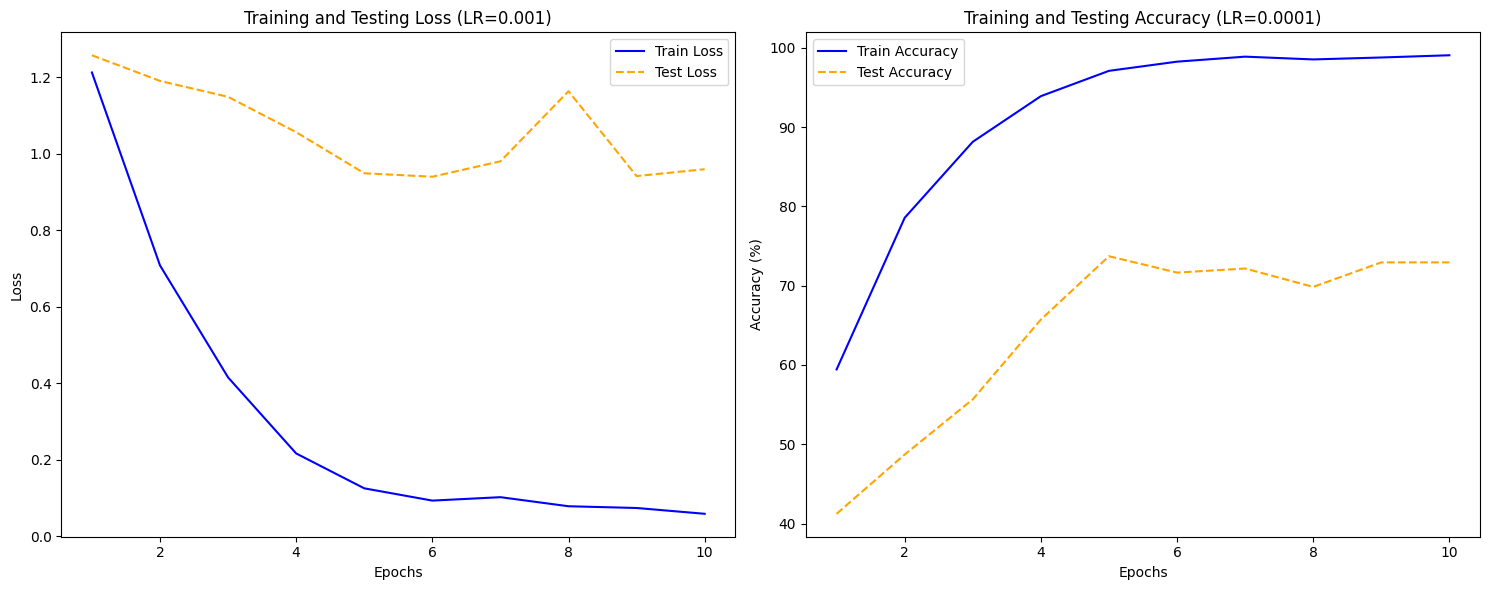

In [30]:
import matplotlib.pyplot as plt

# Find the results for the learning rate 0.001
lr_results = next(result for result in results_lr if result['lr'] == 0.0001)

# Set up the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Training and Testing Loss
ax1.plot(range(1, num_epochs + 1), lr_results['train_loss'], label='Train Loss', color='blue', linestyle='-')
ax1.plot(range(1, num_epochs + 1), lr_results['test_loss'], label='Test Loss', color='orange', linestyle='--')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Testing Loss (LR=0.0001)')
ax1.legend()

# Plot 2: Training and Testing Accuracy
ax2.plot(range(1, num_epochs + 1), lr_results['train_acc'], label='Train Accuracy', color='blue', linestyle='-')
ax2.plot(range(1, num_epochs + 1), lr_results['test_acc'], label='Test Accuracy', color='orange', linestyle='--')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Testing Accuracy (LR=0.0001)')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()


### Data Augmentation and Update Model Parameters

In [34]:
# Enhanced Data Transform with Augmentations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Apply to training dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [35]:
# Model with Dropout
def create_model_dropout(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True)
    if hasattr(model, 'fc'):
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    elif hasattr(model, 'classifier'):
        num_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    else:
        raise Exception('Model architecture not supported.')
    return model.to(device)

In [36]:
learning_rate = 0.001
num_epochs = 10
model_name = 'resnet50'
criterion = nn.CrossEntropyLoss()  # Renaming loss function to match `criterion`
results = []

model = create_model_dropout(model_name, num_classes)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model and collect training loss and accuracy
train_loss, train_acc, test_loss, test_acc = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs
)

# Save model with a unique name based on the learning rate and weight decay
model_save_name = f"{model_name}_Adam_lr{learning_rate}_wd1e-4.pth"
torch.save(model.state_dict(), model_save_name)

# Save results for comparison later
results.append({
    'lr': learning_rate,
    'train_loss': train_loss,
    'train_acc': train_acc,
    'test_loss': test_loss,
    'test_acc': test_acc
})

Epoch [1/10], Train Loss: 0.7048, Train Accuracy: 71.75%, Test Loss: 1.2691, Test Accuracy: 59.02%
Epoch [2/10], Train Loss: 0.3397, Train Accuracy: 89.33%, Test Loss: 1.8439, Test Accuracy: 55.67%
Epoch [3/10], Train Loss: 0.2737, Train Accuracy: 91.93%, Test Loss: 0.9062, Test Accuracy: 78.35%
Epoch [4/10], Train Loss: 0.1988, Train Accuracy: 92.77%, Test Loss: 1.0808, Test Accuracy: 76.80%
Epoch [5/10], Train Loss: 0.1380, Train Accuracy: 95.65%, Test Loss: 1.2530, Test Accuracy: 75.00%
Epoch [6/10], Train Loss: 0.1243, Train Accuracy: 96.88%, Test Loss: 1.1728, Test Accuracy: 76.03%
Epoch [7/10], Train Loss: 0.0797, Train Accuracy: 97.19%, Test Loss: 1.1048, Test Accuracy: 77.58%
Epoch [8/10], Train Loss: 0.0630, Train Accuracy: 97.68%, Test Loss: 1.1433, Test Accuracy: 77.32%
Epoch [9/10], Train Loss: 0.0675, Train Accuracy: 97.65%, Test Loss: 1.0932, Test Accuracy: 79.38%
Epoch [10/10], Train Loss: 0.0501, Train Accuracy: 98.49%, Test Loss: 1.0107, Test Accuracy: 79.12%


### Effects of Different Augmentation Techniques Using ResNet18

In [41]:
from timm.data.transforms import RandomResizedCropAndInterpolation
from timm.data import create_transform
from timm.data.auto_augment import rand_augment_transform

# Basic transform for test data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Augmentation Techniques
aug_transforms = {
    'RandomResizedCropAndInterpolation': transforms.Compose([
        RandomResizedCropAndInterpolation(size=224, interpolation='random'),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'create_transform_auto_augment': create_transform(
        input_size=224, is_training=True, auto_augment='rand-m9-mstd0.5'
    )
}


In [47]:
learning_rate = 0.001
num_epochs = 20
model_name = 'resnet18'  # Using a simpler model
criterion = nn.CrossEntropyLoss()
results = []

# Iterate over each augmentation technique
for aug_name, train_transform in aug_transforms.items():
    print(f"\nTraining with augmentation: {aug_name}")

    # Apply the transform to the training dataset
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize model, optimizer, and scheduler
    model = create_model_dropout(model_name, num_classes)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Train and evaluate the model
    train_loss, train_acc, test_loss, test_acc = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs
    )

    # Save model with augmentation name
    model_save_name = f"{model_name}_Adam_{aug_name}.pth"
    torch.save(model.state_dict(), model_save_name)

    # Save results for comparison
    results.append({
        'augmentation': aug_name,
        'lr': learning_rate,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'test_loss': test_loss,
        'test_acc': test_acc
    })



Training with augmentation: RandomResizedCropAndInterpolation
Epoch [1/20], Train Loss: 0.7296, Train Accuracy: 70.00%, Test Loss: 1.4599, Test Accuracy: 49.48%
Epoch [2/20], Train Loss: 0.4295, Train Accuracy: 84.21%, Test Loss: 1.3661, Test Accuracy: 60.05%
Epoch [3/20], Train Loss: 0.3357, Train Accuracy: 87.75%, Test Loss: 1.6403, Test Accuracy: 56.70%
Epoch [4/20], Train Loss: 0.3270, Train Accuracy: 88.32%, Test Loss: 1.8172, Test Accuracy: 62.63%
Epoch [5/20], Train Loss: 0.2460, Train Accuracy: 90.35%, Test Loss: 2.2297, Test Accuracy: 67.53%
Epoch [6/20], Train Loss: 0.1824, Train Accuracy: 93.23%, Test Loss: 1.6842, Test Accuracy: 74.74%
Epoch [7/20], Train Loss: 0.1679, Train Accuracy: 93.40%, Test Loss: 1.6191, Test Accuracy: 73.97%
Epoch [8/20], Train Loss: 0.1789, Train Accuracy: 94.91%, Test Loss: 1.3156, Test Accuracy: 76.55%
Epoch [9/20], Train Loss: 0.1775, Train Accuracy: 94.70%, Test Loss: 1.5073, Test Accuracy: 75.00%
Epoch [10/20], Train Loss: 0.1391, Train Accur

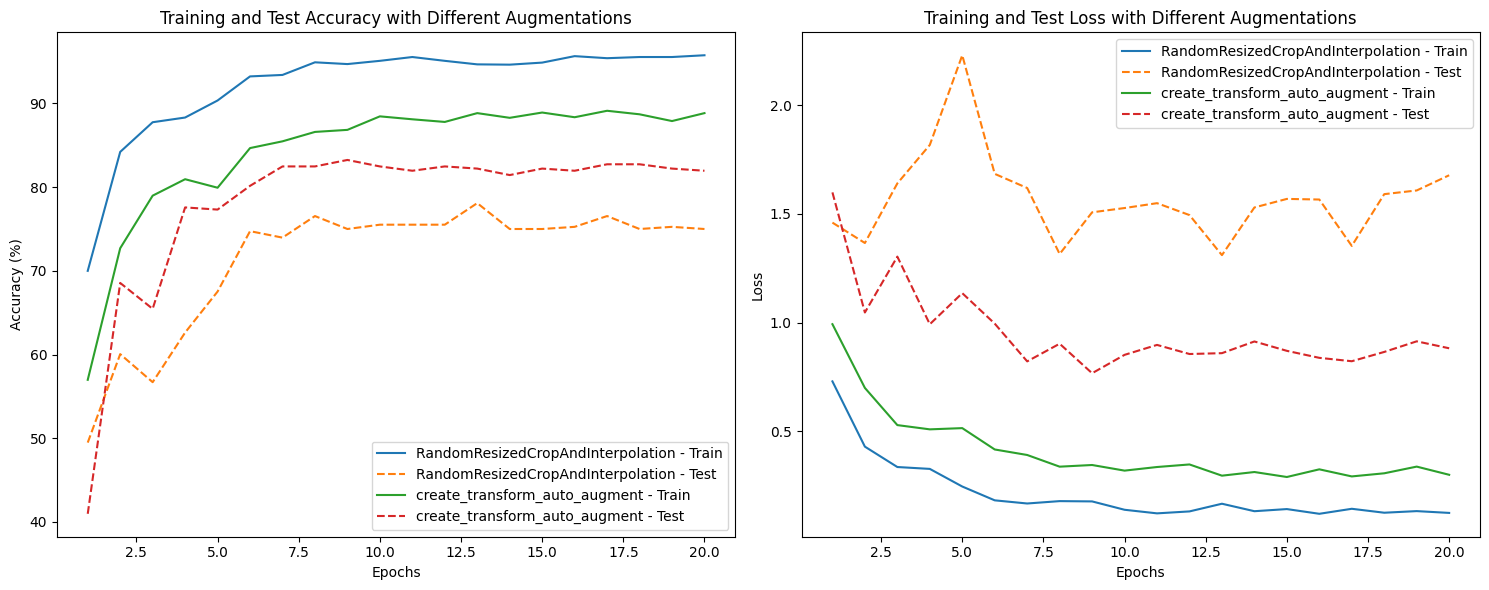

In [48]:
# Plot Training and Test Accuracy for Different Augmentations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
for result in results:
    ax1.plot(range(1, num_epochs + 1), result['train_acc'], label=f"{result['augmentation']} - Train", linestyle='-')
    ax1.plot(range(1, num_epochs + 1), result['test_acc'], label=f"{result['augmentation']} - Test", linestyle='--')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training and Test Accuracy with Different Augmentations')
ax1.legend()

# Loss Plot
for result in results:
    ax2.plot(range(1, num_epochs + 1), result['train_loss'], label=f"{result['augmentation']} - Train", linestyle='-')
    ax2.plot(range(1, num_epochs + 1), result['test_loss'], label=f"{result['augmentation']} - Test", linestyle='--')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Test Loss with Different Augmentations')
ax2.legend()

plt.tight_layout()
plt.show()

### Effects of Different Optimizers and Pooling Strategies Using DenseNet121

In [49]:
model.global_pool

SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))

In [50]:
# Define optimizers dictionary with lambda functions for SGD and AdamW
optimizers = {
    'SGD': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
    'AdamW': optim.AdamW
}

learning_rate = 0.001
num_epochs = 10
model_name = 'densenet121' 
criterion = nn.CrossEntropyLoss()
results_opt = []

# Loop through each optimizer
for opt_name, opt_func in optimizers.items():
    print(f"\nTraining with optimizer: {opt_name}")

    # Initialize DenseNet model with global max pooling and move to device
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes, global_pool='max')
    model = model.to(device)
    
    # Initialize optimizer and scheduler
    optimizer = opt_func(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Train the model and evaluate it
    train_loss, train_acc, test_loss, test_acc = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs
    )

    # Save model with a unique name based on the optimizer
    model_save_name = f"{model_name}_{opt_name}_maxpool.pth"
    torch.save(model.state_dict(), model_save_name)

    # Save results for comparison
    results_opt.append({
        'optimizer': opt_name,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'test_loss': test_loss,
        'test_acc': test_acc
    })


Training with optimizer: SGD


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Epoch [1/10], Train Loss: 5.6018, Train Accuracy: 52.98%, Test Loss: 9.4215, Test Accuracy: 46.91%
Epoch [2/10], Train Loss: 3.9661, Train Accuracy: 59.47%, Test Loss: 5.2523, Test Accuracy: 52.58%
Epoch [3/10], Train Loss: 1.9174, Train Accuracy: 65.72%, Test Loss: 1.7780, Test Accuracy: 63.66%
Epoch [4/10], Train Loss: 1.1823, Train Accuracy: 66.77%, Test Loss: 2.6372, Test Accuracy: 60.57%
Epoch [5/10], Train Loss: 0.9853, Train Accuracy: 71.47%, Test Loss: 3.2728, Test Accuracy: 64.43%
Epoch [6/10], Train Loss: 0.6893, Train Accuracy: 75.86%, Test Loss: 1.6124, Test Accuracy: 71.91%
Epoch [7/10], Train Loss: 0.6020, Train Accuracy: 76.91%, Test Loss: 1.4492, Test Accuracy: 72.68%
Epoch [8/10], Train Loss: 0.6112, Train Accuracy: 77.61%, Test Loss: 1.4031, Test Accuracy: 72.16%
Epoch [9/10], Train Loss: 0.6038, Train Accuracy: 79.26%, Test Loss: 1.4342, Test Accuracy: 72.42%
Epoch [10/10], Train Loss: 0.5901, Train Accuracy: 78.60%, Test Loss: 1.2609, Test Accuracy: 74.74%

Training

### Effects of Different Schedulers with AdamW optimizer

In [52]:
# Define schedulers dictionary with CosineAnnealingLR and ExponentialLR
schedulers = {
    'CosineAnnealingLR': lambda opt: optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs),
    'ExponentialLR': lambda opt: optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
}

learning_rate = 0.001
num_epochs = 10
model_name = 'densenet121'  # Using DenseNet-121 with dropout
criterion = nn.CrossEntropyLoss()
results_sched = []

# Loop through each scheduler
for sched_name, sched_func in schedulers.items():
    print(f"\nTraining with scheduler: {sched_name}")

    model = create_model_dropout(model_name, num_classes)
    model = model.to(device)
    
    # Initialize AdamW optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = sched_func(optimizer)

    # Train the model and evaluate it
    train_loss, train_acc, test_loss, test_acc = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs
    )

    # Save model with a unique name based on the scheduler
    model_save_name = f"{model_name}_AdamW_{sched_name}.pth"
    torch.save(model.state_dict(), model_save_name)

    # Save results for comparison
    results_sched.append({
        'scheduler': sched_name,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'test_loss': test_loss,
        'test_acc': test_acc
    })


Training with scheduler: CosineAnnealingLR
Epoch [1/10], Train Loss: 0.9434, Train Accuracy: 60.84%, Test Loss: 1.3099, Test Accuracy: 59.28%
Epoch [2/10], Train Loss: 0.7075, Train Accuracy: 72.70%, Test Loss: 1.1432, Test Accuracy: 63.40%
Epoch [3/10], Train Loss: 0.6289, Train Accuracy: 75.30%, Test Loss: 1.5928, Test Accuracy: 65.72%
Epoch [4/10], Train Loss: 0.5744, Train Accuracy: 78.42%, Test Loss: 1.6408, Test Accuracy: 65.98%
Epoch [5/10], Train Loss: 0.4583, Train Accuracy: 82.74%, Test Loss: 1.1705, Test Accuracy: 70.62%
Epoch [6/10], Train Loss: 0.4337, Train Accuracy: 83.51%, Test Loss: 1.1314, Test Accuracy: 77.06%
Epoch [7/10], Train Loss: 0.3905, Train Accuracy: 85.33%, Test Loss: 0.9333, Test Accuracy: 80.15%
Epoch [8/10], Train Loss: 0.3289, Train Accuracy: 87.12%, Test Loss: 0.7903, Test Accuracy: 83.25%
Epoch [9/10], Train Loss: 0.2836, Train Accuracy: 88.74%, Test Loss: 0.8280, Test Accuracy: 80.41%
Epoch [10/10], Train Loss: 0.2432, Train Accuracy: 90.81%, Test L

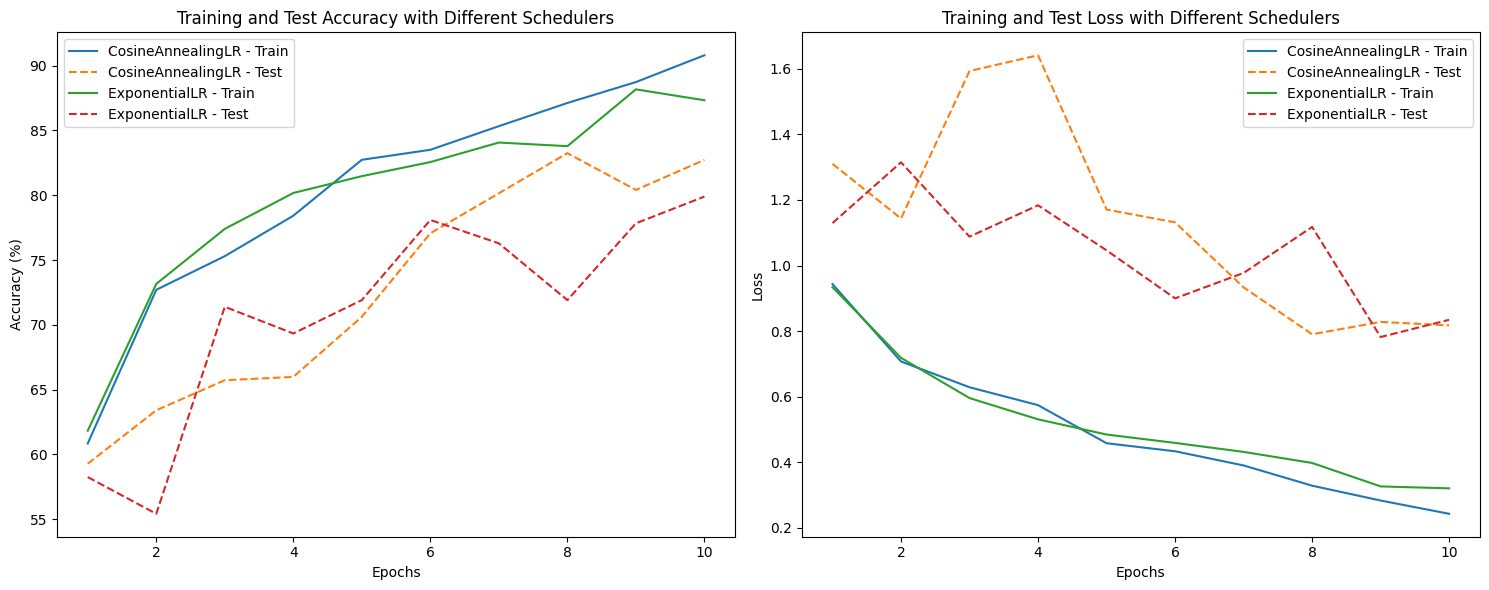

In [53]:
# Plot Training and Test Accuracy for Different Schedulers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
for result in results_sched:
    ax1.plot(range(1, num_epochs + 1), result['train_acc'], label=f"{result['scheduler']} - Train", linestyle='-')
    ax1.plot(range(1, num_epochs + 1), result['test_acc'], label=f"{result['scheduler']} - Test", linestyle='--')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training and Test Accuracy with Different Schedulers')
ax1.legend()

# Loss Plot
for result in results_sched:
    ax2.plot(range(1, num_epochs + 1), result['train_loss'], label=f"{result['scheduler']} - Train", linestyle='-')
    ax2.plot(range(1, num_epochs + 1), result['test_loss'], label=f"{result['scheduler']} - Test", linestyle='--')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Test Loss with Different Schedulers')
ax2.legend()

plt.tight_layout()
plt.show()

### Model Inference

In [75]:
import time

# Loads a saved model, exports to TorchScript, evaluates accuracy and latency.
def model_inference(model_file, model_arch, num_classes, test_loader, device, model_creation_mapping):

    if model_file in model_creation_mapping:
        create_fn = model_creation_mapping[model_file]
    else:
        create_fn = create_model
    
    # Create the model
    try:
        model = create_fn(model_arch, num_classes)
    except Exception as e:
        print(f"Error creating model for '{model_arch}': {e}")
        return None
    
    # Load the saved state dictionary
    try:
        state_dict = torch.load(model_file, map_location=device)
        model.load_state_dict(state_dict)
    except RuntimeError as e:
        print(f"Error loading state_dict for '{model_arch}': {e}")
        return None
    except FileNotFoundError:
        print(f"Model file '{model_file}' not found.")
        return None
    
    model = model.to(device)
    model.eval()
    
    # Export to TorchScript
    try:
        scripted_model = torch.jit.script(model)
        scripted_model_file = model_file.replace('.pth', '_scripted.pt')
        scripted_model.save(scripted_model_file)
        model_to_evaluate = model
        model_size = os.path.getsize(scripted_model_file) / 1e6  # in MB
    except Exception as e:
        print(f"Error scripting model '{model_arch}': {e}")
        return None
    
    # Evaluate accuracy
    criterion = nn.CrossEntropyLoss()
    test_loss, test_accuracy = evaluate_model(model_to_evaluate, test_loader, criterion)
    
    # Measure latency
    latency = measure_latency(model_to_evaluate, device)
    
    # Prepare metrics dictionary
    metrics = {
        'model_file': model_file,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'latency_ms': latency,
        'model_size_MB': model_size,
    }
    
    return metrics




In [76]:
# Evaluate the model's accuracy and loss on the test dataset.
def evaluate_model(model, test_loader, criterion):
    
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [77]:
# Measures the average latency of the model over a number of iterations
def measure_latency(model, device, input_size=(1, 3, 224, 224), iterations=100):
   
    model.eval()
    inputs = torch.randn(input_size).to(device)
    
    # Warm-up
    for _ in range(10):
        _ = model(inputs)
    
    # Measure latency
    start_time = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            _ = model(inputs)
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / iterations * 1000  # Convert to milliseconds
    return avg_latency

In [ ]:
# Mapping of model filenames to their creation functions
# Although it seems irrelevant here, it is needed if the model is created using different functions
# such as resnet50_Adam models were created using create_model which has different parameters
model_creation_mapping = {
    'densenet121_AdamW_CosineAnnealingLR.pth': create_model_dropout,
    'resnet18_Adam_create_transform_auto_augment.pth': create_model_dropout,
    'resnet50_Adam_lr0.001_wd1e-4.pth': create_model_dropout,
}

### Model Inference Comparison

The model files were in the same directory while running this code. Update the model file locations if downloaded in a different directory

In [82]:
# Reuse existing test_loader and num_classes from training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of models to test
models = [
     ('densenet121_AdamW_CosineAnnealingLR.pth', 'densenet121'),
     ('resnet18_Adam_create_transform_auto_augment.pth', 'resnet18'),
     ('resnet50_Adam_lr0.001_wd1e-4.pth', 'resnet50'),
]

# Initialize list to store results
results = []

# Perform inference on each model and store metrics
for model_file, model_arch in models:
    print(f"\nEvaluating {model_file}...")

    
    metrics = model_inference(model_file, model_arch, num_classes, test_loader, device, model_creation_mapping)
    if metrics is not None:
        results.append(metrics)
    else:
        print(f"Failed to evaluate model '{model_file}'.")

# Display the collected results
for result in results:
    print(f"\nResults for {result['model_file']}:")
    print(f" - Test Loss: {result['test_loss']:.4f}")
    print(f" - Test Accuracy: {result['test_accuracy']:.2f}%")
    print(f" - Latency: {result['latency_ms']:.2f} ms")
    print(f" - Model Size: {result['model_size_MB']:.2f} MB")


Evaluating densenet121_AdamW_CosineAnnealingLR.pth...

Evaluating resnet18_Adam_create_transform_auto_augment.pth...

Evaluating resnet50_Adam_lr0.001_wd1e-4.pth...

Results for densenet121_AdamW_CosineAnnealingLR.pth:
 - Test Loss: 0.8175
 - Test Accuracy: 82.73%
 - Latency: 18.72 ms
 - Model Size: 30.77 MB

Results for resnet18_Adam_create_transform_auto_augment.pth:
 - Test Loss: 0.8819
 - Test Accuracy: 81.96%
 - Latency: 2.66 ms
 - Model Size: 45.92 MB

Results for resnet50_Adam_lr0.001_wd1e-4.pth:
 - Test Loss: 1.0107
 - Test Accuracy: 79.12%
 - Latency: 6.85 ms
 - Model Size: 98.65 MB


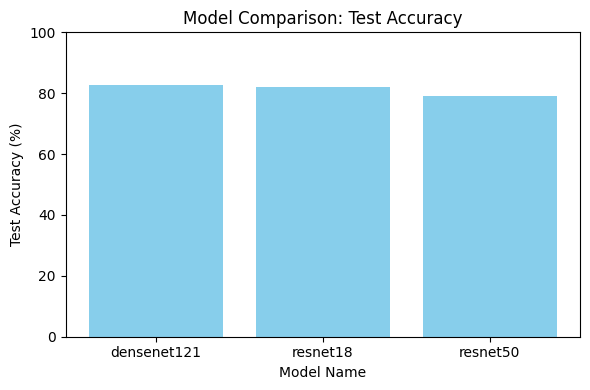

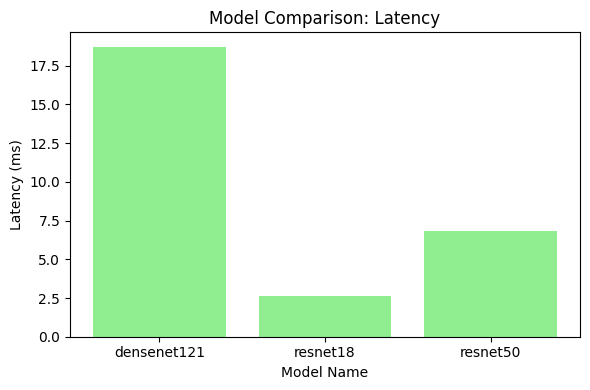

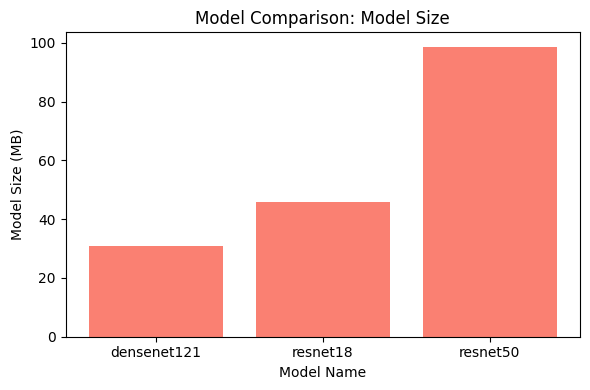

In [144]:
# Plots the accuracy, latency, and model size of multiple models as charts.
def plot_model_metrics(results):
    
    # Extract metrics from results
    model_names = [result['model_file'].split('_')[0] for result in results]
    accuracies = [result['test_accuracy'] for result in results]
    latencies = [result['latency_ms'] for result in results]
    model_sizes = [result['model_size_MB'] for result in results]
    
    # Plot Test Accuracy
    plt.figure(figsize=(6, 4))
    plt.bar(model_names, accuracies, color='skyblue')
    plt.ylabel('Test Accuracy (%)')
    plt.xlabel('Model Name')
    plt.title('Model Comparison: Test Accuracy')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    # Plot Latency
    plt.figure(figsize=(6, 4))
    plt.bar(model_names, latencies, color='lightgreen')
    plt.ylabel('Latency (ms)')
    plt.xlabel('Model Name')
    plt.title('Model Comparison: Latency')
    plt.tight_layout()
    plt.show()

    # Plot Model Size
    plt.figure(figsize=(6, 4))
    plt.bar(model_names, model_sizes, color='salmon')
    plt.ylabel('Model Size (MB)')
    plt.xlabel('Model Name')
    plt.title('Model Comparison: Model Size')
    plt.tight_layout()
    plt.show()

# Call the function with the collected results
plot_model_metrics(results)

### Test with Random Image

In [107]:
# class names
class_names = [
    'glioma_tumor',
    'meningioma_tumor',
    'no_tumor',
    'pituitary_tumor'
]

In [145]:
# Inspect class_to_idx and classes
print("Class to Index Mapping:")
print(test_dataset.class_to_idx)


Class to Index Mapping:
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [108]:
def load_models(models, model_creation_mapping, num_classes, device):
    """
    Loads all specified models and returns a dictionary of model_arch: model
    """
    loaded_models = {}
    for model_file, model_arch in models:
        print(f"Loading model '{model_file}'...")
        create_fn = model_creation_mapping.get(model_file, None)
        if create_fn is None:
            print(f"No creation function for model '{model_file}', skipping.")
            continue
        try:
            model = create_fn(model_arch, num_classes)
        except Exception as e:
            print(f"Error creating model for '{model_arch}': {e}")
            continue
        # Load state dict
        try:
            state_dict = torch.load(model_file, map_location=device)
            model.load_state_dict(state_dict)
        except RuntimeError as e:
            print(f"Error loading state_dict for '{model_arch}': {e}")
            continue
        except FileNotFoundError:
            print(f"Model file '{model_file}' not found.")
            continue
        model = model.to(device)
        model.eval()
        loaded_models[model_arch] = model
    return loaded_models


In [146]:
def get_image(test_loader):
    """
    Retrieves an image and its label from the test_loader.
    Returns the image tensor and label index.
    """
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    image = images[0].unsqueeze(0)  
    label = labels[0].item()
    return image, label

In [147]:
def invert_normalize(image_tensor):
    """
    Inverts the normalization of the image tensor for display purposes.
    """
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image_inv = inv_normalize(image_tensor.squeeze(0)).clamp(0, 1)
    image_np = image_inv.permute(1, 2, 0).numpy()
    return image_np

In [151]:
def visualize_predictions(image, true_label, predictions, class_names):
    """
    Visualizes the image and the predictions from different models.
    """
    # Invert normalization for display
    image_np = invert_normalize(image)
    # Create a figure with two parts: image and table (vertically arranged)
    fig = plt.figure(figsize=(10,12))

    # Add image subplot
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.imshow(image_np)
    ax1.set_title(f"True Label: {class_names[true_label]}")
    ax1.axis('off')

    # Prepare table data
    model_names = list(predictions.keys())
    table_data = []
    for idx, class_name in enumerate(class_names):
        row = [class_name]
        for model in model_names:
            prob = predictions[model]['probabilities'][idx]
            row.append(f"{prob*100:.2f}%")
        table_data.append(row)

    # Create table subplot
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.axis('off') 

    column_labels = ['Class'] + model_names
    table = ax2.table(cellText=table_data,
                      colLabels=column_labels,
                      cellLoc='center',
                      loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)

    # Highlight the predicted class in each model
    for col, model in enumerate(model_names, start=1):
        predicted = predictions[model]['predicted']
        table_idx = predicted + 1  # +1 to account for header
        table[(table_idx, col)].set_facecolor('lightgreen')
        table[(table_idx, col)].get_text().set_weight('bold')

    # Add a caption below the table
    fig.text(0.5, 0.02, 'Predicted Probabilities (%) for Each Class across different Models', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

In [152]:
def main_visualization(models, model_creation_mapping, test_loader, device, num_classes, class_names):
    """
    Main function to load models, select an image, perform inference, and visualize.
    """
    # Load models
    loaded_models = load_models(models, model_creation_mapping, num_classes, device)
    
    if not loaded_models:
        print("No models loaded successfully.")
        return
    
    # Get a random image
    image, true_label = get_random_image(test_loader)
    
    # Pass the image through each model
    predictions = {}
    for model_arch, model in loaded_models.items():
        with torch.no_grad():
            input_tensor = image.to(device)
            outputs = model(input_tensor)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
            predicted = np.argmax(probabilities)
            predictions[model_arch] = {
                'probabilities': probabilities,
                'predicted': predicted
            }
    
    # Visualize
    visualize_predictions(image, true_label, predictions, class_names)

Loading model 'densenet121_AdamW_CosineAnnealingLR.pth'...
Loading model 'resnet18_Adam_create_transform_auto_augment.pth'...
Loading model 'resnet50_Adam_lr0.001_wd1e-4.pth'...


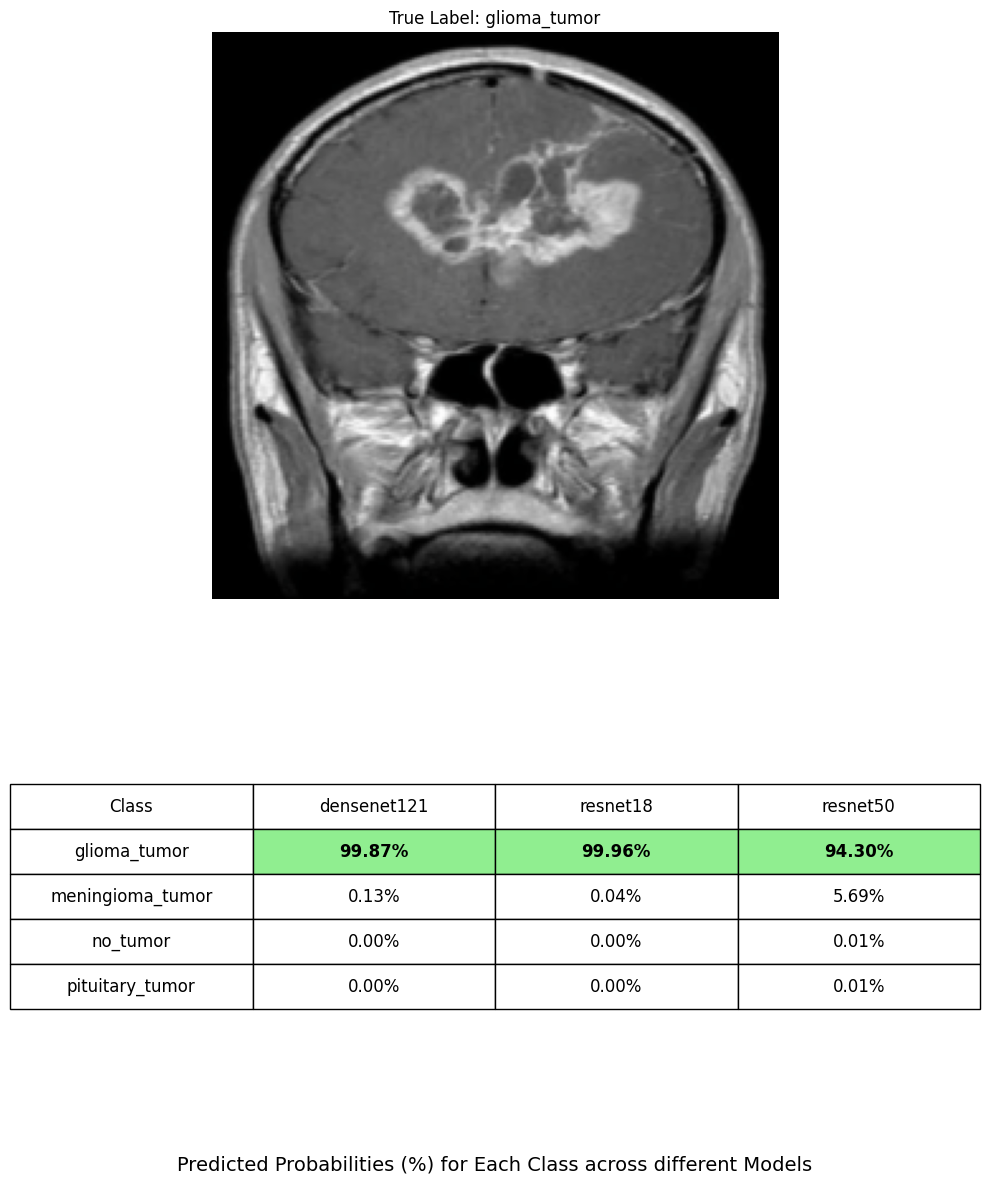

In [153]:

main_visualization(models, model_creation_mapping, test_loader, device, num_classes, class_names)